# Complete CLIP Triplet Network - Inference Pipeline

This notebook contains the **complete end-to-end inference system** for the fine-tuned CLIP triplet network.

## What This Notebook Does:
1. **Setup & Configuration** - Import libraries and set parameters
2. **Model Architecture** - Define CLIPTripletModel, ProjectionHead, TripletLoss
3. **Dataset Classes** - Data loading for inference
4. **Utility Functions** - Helper functions for embeddings and visualization
5. **Inference Engine** - ImageSimilarityEngine for similarity search
6. **Build Database** - Extract embeddings for all images (auto-checks if exists!)
7. **Test Queries** - Find similar images and visualize results
8. **Demos** - Various use cases and examples

## Quick Start:
1. **Run all cells in order** - You can run this every time!
2. **Section 6** automatically checks if database exists (won't rebuild unnecessarily)
3. **Section 7** excludes query image and removes duplicates from results

## Features:
- Auto-detects if database already exists
- Query image is never included in results
- Duplicate images are automatically filtered
- Works on both CPU and GPU (auto-detects)

---

## 1. Setup & Configuration

In [22]:
# Install required packages (run once)
# %pip install "torch" "torchvision"
# %pip install ftfy regex tqdm
# %pip install git+https://github.com/openai/CLIP.git
# %pip install pillow numpy matplotlib seaborn

In [23]:
# Import all required libraries
import os
import sys
import json
import pickle
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Callable, Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import clip

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(f"✓ PyTorch {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
print(f"✓ Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ PyTorch 2.9.1+cpu
✓ CUDA available: False
✓ Device: cpu


In [24]:
# Configuration Settings
class Config:
    # Model settings
    CLIP_MODEL_NAME = "ViT-B/32"
    USE_PROJECTION_HEAD = True
    PROJECTION_DIM = 128
    PROJECTION_DROPOUT = 0.1
    
    # Training settings (for reference)
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    TRIPLET_MARGIN = 0.3
    
    # Paths - Updated for new repository structure
    DATA_DIR = Path("../../datasets/animals/raw-img")
    CHECKPOINT_PATH = "../../models/clip_finetuned/checkpoints/best_triplet_model.pth"
    DATABASE_PATH = "../../models/clip_finetuned/outputs/embedding_database.pkl"
    OUTPUT_DIR = Path("../../models/clip_finetuned/outputs")
    
    # Inference settings
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TOP_K = 10
    DISTANCE_METRIC = 'cosine'  # 'cosine' or 'euclidean'

config = Config()

print("Configuration:")
print(f"  Model: {config.CLIP_MODEL_NAME}")
print(f"  Projection dim: {config.PROJECTION_DIM}")
print(f"  Device: {config.DEVICE}")
print(f"  Data directory: {config.DATA_DIR}")

Configuration:
  Model: ViT-B/32
  Projection dim: 128
  Device: cpu
  Data directory: ..\..\datasets\animals\raw-img


## 2. Model Architecture

In [25]:
class ProjectionHead(nn.Module):
    """
    Projection head to reduce embedding dimensionality.
    Architecture: Linear -> BatchNorm -> ReLU -> Dropout -> Linear -> L2 Norm
    """
    
    def __init__(self, input_dim: int, output_dim: int, dropout: float = 0.1):
        super().__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(input_dim, output_dim)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.projection(x)
        # L2 normalize to unit hypersphere
        x = F.normalize(x, p=2, dim=1)
        return x

print("✓ ProjectionHead defined")

✓ ProjectionHead defined


In [26]:
class CLIPTripletModel(nn.Module):
    """
    Triplet network using CLIP image encoder with projection head.
    """
    
    def __init__(
        self,
        clip_model_name: str = "ViT-B/32",
        projection_dim: Optional[int] = None,
        dropout: float = 0.1,
        freeze_clip: bool = True
    ):
        super().__init__()
        
        # Load pretrained CLIP model - Updated path for new structure
        self.clip_model, _ = clip.load(
            clip_model_name, 
            device="cpu",
            download_root="../../models/clip_finetuned/clip_models"
        )
        
        # Get CLIP embedding dimension
        if "RN" in clip_model_name:
            self.clip_embedding_dim = 1024 if "RN50x" in clip_model_name else 512
        else:
            self.clip_embedding_dim = 768 if "ViT-L" in clip_model_name else 512
        
        # Freeze CLIP if specified
        if freeze_clip:
            self.freeze_clip_backbone()
        
        # Optional projection head
        self.use_projection = projection_dim is not None
        if self.use_projection:
            self.projection_head = ProjectionHead(
                input_dim=self.clip_embedding_dim,
                output_dim=projection_dim,
                dropout=dropout
            )
            self.output_dim = projection_dim
        else:
            self.projection_head = None
            self.output_dim = self.clip_embedding_dim
        
        print(f"Model initialized:")
        print(f"  CLIP: {clip_model_name}")
        print(f"  CLIP dim: {self.clip_embedding_dim}")
        print(f"  Projection dim: {projection_dim if self.use_projection else 'None'}")
        print(f"  Output dim: {self.output_dim}")
    
    def freeze_clip_backbone(self):
        for param in self.clip_model.parameters():
            param.requires_grad = False
    
    def unfreeze_clip_backbone(self):
        for param in self.clip_model.parameters():
            param.requires_grad = True
    
    def unfreeze_last_n_layers(self, n: int):
        self.freeze_clip_backbone()
        if hasattr(self.clip_model.visual, 'transformer'):
            total_blocks = len(self.clip_model.visual.transformer.resblocks)
            for i in range(total_blocks - n, total_blocks):
                for param in self.clip_model.visual.transformer.resblocks[i].parameters():
                    param.requires_grad = True
    
    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        with torch.set_grad_enabled(self.training):
            clip_features = self.clip_model.encode_image(image).float()
        
        if self.use_projection:
            embeddings = self.projection_head(clip_features)
        else:
            embeddings = F.normalize(clip_features, p=2, dim=1)
        
        return embeddings
    
    def forward(self, anchor, positive, negative):
        anchor_emb = self.encode_image(anchor)
        positive_emb = self.encode_image(positive)
        negative_emb = self.encode_image(negative)
        return anchor_emb, positive_emb, negative_emb
    
    def get_embedding(self, image: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            return self.encode_image(image)
    
    def count_parameters(self) -> dict:
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total': total, 'trainable': trainable, 'frozen': total - trainable}

print("✓ CLIPTripletModel defined")

✓ CLIPTripletModel defined


In [27]:
class TripletLoss(nn.Module):
    """
    Triplet Margin Loss for metric learning.
    """
    
    def __init__(self, margin: float = 0.3, distance_metric: str = 'euclidean'):
        super().__init__()
        self.margin = margin
        self.distance_metric = distance_metric
    
    def forward(self, anchor, positive, negative):
        if self.distance_metric == 'euclidean':
            pos_dist = F.pairwise_distance(anchor, positive, p=2)
            neg_dist = F.pairwise_distance(anchor, negative, p=2)
        else:
            pos_dist = 1 - F.cosine_similarity(anchor, positive)
            neg_dist = 1 - F.cosine_similarity(anchor, negative)
        
        losses = F.relu(pos_dist - neg_dist + self.margin)
        return losses.mean()

print("✓ TripletLoss defined")

✓ TripletLoss defined


## 3. Dataset Classes

In [28]:
class InferenceDataset(Dataset):
    """
    Dataset for inference - loads images without triplet sampling.
    """
    
    def __init__(self, root_dir: str, transform=None, return_paths: bool = True):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.return_paths = return_paths
        
        if self.transform is None:
            _, self.transform = clip.load("ViT-B/32", device="cpu")
        
        self.image_paths = []
        self.labels = []
        self._load_images()
        
        print(f"Dataset loaded: {len(self.image_paths)} images")
    
    def _load_images(self):
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
        subdirs = [d for d in self.root_dir.iterdir() if d.is_dir()]
        
        if subdirs:
            for subdir in subdirs:
                label = subdir.name
                for ext in image_extensions:
                    for img_path in subdir.glob(f'*{ext}'):
                        self.image_paths.append(str(img_path))
                        self.labels.append(label)
                    for img_path in subdir.glob(f'*{ext.upper()}'):
                        self.image_paths.append(str(img_path))
                        self.labels.append(label)
        else:
            for ext in image_extensions:
                for img_path in self.root_dir.glob(f'*{ext}'):
                    self.image_paths.append(str(img_path))
                    self.labels.append(None)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.return_paths:
            return image, img_path, self.labels[idx]
        else:
            return image

print("✓ InferenceDataset defined")

✓ InferenceDataset defined


## 4. Utility Functions

In [29]:
def save_embeddings(embeddings: np.ndarray, metadata: Dict[str, Any], filepath: str):
    """Save embeddings and metadata to pickle file."""
    data = {'embeddings': embeddings, 'metadata': metadata}
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"✓ Embeddings saved: {filepath}")
    print(f"  Shape: {embeddings.shape}")

def load_embeddings(filepath: str) -> Dict[str, Any]:
    """Load embeddings and metadata from pickle file."""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    print(f"✓ Embeddings loaded: {filepath}")
    print(f"  Shape: {data['embeddings'].shape}")
    return data

def compute_cosine_similarity(query_embedding: np.ndarray, database_embeddings: np.ndarray) -> np.ndarray:
    """Compute cosine similarity between query and database."""
    if query_embedding.ndim == 1:
        query_embedding = query_embedding.reshape(1, -1)
    
    query_norm = query_embedding / (np.linalg.norm(query_embedding, axis=1, keepdims=True) + 1e-8)
    db_norm = database_embeddings / (np.linalg.norm(database_embeddings, axis=1, keepdims=True) + 1e-8)
    similarities = np.dot(query_norm, db_norm.T).squeeze()
    return similarities

def compute_euclidean_distance(query_embedding: np.ndarray, database_embeddings: np.ndarray) -> np.ndarray:
    """Compute Euclidean distance between query and database."""
    if query_embedding.ndim == 1:
        query_embedding = query_embedding.reshape(1, -1)
    distances = np.linalg.norm(database_embeddings - query_embedding, axis=1)
    return distances

def visualize_similar_images(
    query_image_path: str,
    similar_image_paths: list,
    similarities: list,
    max_display: int = 5,
    figsize: tuple = (15, 3)
):
    """Visualize query image and top similar images."""
    n_display = min(max_display, len(similar_image_paths))
    fig, axes = plt.subplots(1, n_display + 1, figsize=figsize)
    
    # Query image
    query_img = Image.open(query_image_path)
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Similar images
    for i in range(n_display):
        img = Image.open(similar_image_paths[i])
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f'Rank {i+1}\nSim: {similarities[i]:.3f}', fontsize=10)
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Utility functions defined")

✓ Utility functions defined


## 5. Inference Engine

In [30]:
class ImageSimilarityEngine:
    """
    Engine for image similarity search using fine-tuned CLIP triplet model.
    """
    
    def __init__(self, model_path: str, data_dir: str, device: str = "auto"):
        if device == "auto":
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        
        print(f"Using device: {self.device}")
        self.data_dir = Path(data_dir)
        
        # Load model
        print(f"Loading model from {model_path}...")
        self.model = self._load_model(model_path)
        self.model.to(self.device)
        self.model.eval()
        
        # Get CLIP preprocessing
        _, self.preprocess = clip.load(config.CLIP_MODEL_NAME, device=self.device)
        
        # Placeholders
        self.image_paths = []
        self.embeddings = None
        self.categories = {}
        
        print("✓ Inference engine initialized")
    
    def _load_model(self, checkpoint_path: str) -> CLIPTripletModel:
        model = CLIPTripletModel(
            clip_model_name=config.CLIP_MODEL_NAME,
            projection_dim=config.PROJECTION_DIM if config.USE_PROJECTION_HEAD else None,
            dropout=config.PROJECTION_DROPOUT,
            freeze_clip=False
        )
        
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"Model loaded from epoch {checkpoint['epoch']}")
        if 'best_val_accuracy' in checkpoint:
            print(f"Best validation accuracy: {checkpoint['best_val_accuracy']:.4f}")
        if 'best_val_loss' in checkpoint:
            print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")
        
        return model
    
    def get_image_embedding(self, image_path: str) -> np.ndarray:
        """Generate embedding for a single image."""
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            embedding = self.model.get_embedding(image_tensor)
        
        return embedding.cpu().numpy().flatten()
    
    def build_embedding_database(self, save_path: Optional[str] = None):
        """Build embedding database for all images."""
        print("\nBuilding embedding database...")
        
        # Load dataset
        dataset = InferenceDataset(str(self.data_dir), transform=self.preprocess)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
        
        all_embeddings = []
        all_paths = []
        all_categories = []
        
        # Extract embeddings
        with torch.no_grad():
            for images, paths, labels in tqdm(dataloader, desc="Processing images"):
                images = images.to(self.device)
                embeddings = self.model.get_embedding(images)
                
                all_embeddings.append(embeddings.cpu().numpy())
                all_paths.extend(paths)
                all_categories.extend(labels)
        
        # Concatenate
        self.embeddings = np.vstack(all_embeddings)
        self.image_paths = all_paths
        self.categories = {path: cat for path, cat in zip(all_paths, all_categories)}
        
        # Category distribution
        from collections import Counter
        category_dist = Counter(all_categories)
        
        print(f"\n✓ Embedding database built")
        print(f"  Total images: {len(self.image_paths)}")
        print(f"  Embedding shape: {self.embeddings.shape}")
        print(f"  Categories: {len(category_dist)}")
        for cat, count in sorted(category_dist.items()):
            print(f"    {cat}: {count}")
        
        # Save if path provided
        if save_path:
            metadata = {
                'image_paths': self.image_paths,
                'categories': self.categories,
                'category_distribution': dict(category_dist)
            }
            save_embeddings(self.embeddings, metadata, save_path)
    
    def load_embedding_database(self, filepath: str):
        """Load pre-computed embedding database."""
        data = load_embeddings(filepath)
        self.embeddings = data['embeddings']
        self.image_paths = data['metadata']['image_paths']
        self.categories = data['metadata']['categories']
    
    def find_similar_images(
        self,
        query_image_path: str,
        top_k: int = 10,
        same_category_only: bool = False
    ) -> List[Tuple[str, float, str]]:
        """Find top-k similar images to query."""
        if self.embeddings is None:
            raise ValueError("Database not built. Run build_embedding_database() first.")
        
        # Get query embedding
        query_embedding = self.get_image_embedding(query_image_path)
        
        # Compute similarities
        similarities = compute_cosine_similarity(query_embedding, self.embeddings)
        
        # Filter by category if needed
        if same_category_only:
            query_category = self.categories.get(query_image_path)
            if query_category:
                mask = np.array([self.categories[p] == query_category for p in self.image_paths])
                similarities = np.where(mask, similarities, -np.inf)
        
        # Get top-k indices (excluding query itself)
        top_indices = np.argsort(similarities)[::-1]
        
        # Normalize paths for comparison (handle different path formats)
        query_path_normalized = os.path.normpath(os.path.abspath(query_image_path))
        
        results = []
        seen_paths = set()  # Track already added images to avoid duplicates
        
        for idx in top_indices:
            path = self.image_paths[idx]
            path_normalized = os.path.normpath(os.path.abspath(path))
            
            # Skip if:
            # 1. Same as query image
            # 2. Already added to results (duplicate)
            if path_normalized == query_path_normalized or path in seen_paths:
                continue
            
            sim = similarities[idx]
            cat = self.categories.get(path, 'Unknown')
            results.append((path, sim, cat))
            seen_paths.add(path)
            
            if len(results) >= top_k:
                break
        
        return results
    
    def get_recommendations(
        self,
        query_image_path: str,
        top_k: int = 10,
        diversity_factor: float = 0.3
    ) -> List[Tuple[str, float, str]]:
        """Get diverse recommendations."""
        if self.embeddings is None:
            raise ValueError("Database not built.")
        
        query_embedding = self.get_image_embedding(query_image_path)
        similarities = compute_cosine_similarity(query_embedding, self.embeddings)
        
        # Normalize query path
        query_path_normalized = os.path.normpath(os.path.abspath(query_image_path))
        
        # Greedy diversity selection
        selected = []
        available = list(range(len(self.image_paths)))
        
        # Remove query image from available indices
        for idx in range(len(self.image_paths)):
            path_normalized = os.path.normpath(os.path.abspath(self.image_paths[idx]))
            if path_normalized == query_path_normalized:
                if idx in available:
                    available.remove(idx)
                break
        
        while len(selected) < top_k and available:
            if not selected:
                # First: highest similarity
                best_idx = max(available, key=lambda i: similarities[i])
            else:
                # Balance similarity and diversity
                scores = []
                for idx in available:
                    sim_score = similarities[idx]
                    selected_embs = self.embeddings[selected]
                    div_score = np.min([
                        1 - compute_cosine_similarity(self.embeddings[idx], emb.reshape(1, -1))
                        for emb in selected_embs
                    ])
                    combined = (1 - diversity_factor) * sim_score + diversity_factor * div_score
                    scores.append((idx, combined))
                best_idx = max(scores, key=lambda x: x[1])[0]
            
            selected.append(best_idx)
            available.remove(best_idx)
        
        results = [
            (self.image_paths[idx], similarities[idx], self.categories.get(self.image_paths[idx], 'Unknown'))
            for idx in selected
        ]
        return results

print("✓ ImageSimilarityEngine defined")

✓ ImageSimilarityEngine defined


## 6. Build Embedding Database

**This section automatically checks if the database exists:**
- If database exists -> loads it instantly (< 1 second)
- If database doesn't exist -> builds it (5-10 minutes on CPU)

**You can run this every time** - it won't rebuild unnecessarily!

**What happens during building:**
- Load your fine-tuned model
- Process all images in the dataset
- Extract embeddings
- Save to disk for fast loading later

In [31]:
# Initialize engine
engine = ImageSimilarityEngine(
    model_path=config.CHECKPOINT_PATH,
    data_dir=str(config.DATA_DIR),
    device="auto"
)

Using device: cpu
Loading model from ../../models/clip_finetuned/checkpoints/best_triplet_model.pth...
Model initialized:
  CLIP: ViT-B/32
  CLIP dim: 512
  Projection dim: 128
  Output dim: 128
Model initialized:
  CLIP: ViT-B/32
  CLIP dim: 512
  Projection dim: 128
  Output dim: 128
Model loaded from epoch 13
Best validation accuracy: 0.9996
Best validation loss: 0.0004
Model loaded from epoch 13
Best validation accuracy: 0.9996
Best validation loss: 0.0004
✓ Inference engine initialized
✓ Inference engine initialized


In [32]:
# Build database (only if it doesn't exist)
if os.path.exists(config.DATABASE_PATH):
    print(f"✓ Database already exists at: {config.DATABASE_PATH}")
    print("Loading existing database...")
    engine.load_embedding_database(config.DATABASE_PATH)
else:
    print("Building new database...")
    engine.build_embedding_database(save_path=config.DATABASE_PATH)

Building new database...

Building embedding database...
Dataset loaded: 52358 images
Dataset loaded: 52358 images


Processing images: 100%|██████████| 1637/1637 [1:02:38<00:00,  2.30s/it]



✓ Embedding database built
  Total images: 52358
  Embedding shape: (52358, 128)
  Categories: 10
    butterfly: 4224
    cat: 3336
    chicken: 6196
    cow: 3732
    dog: 9726
    elephant: 2892
    horse: 5246
    sheep: 3640
    spider: 9642
    squirrel: 3724
✓ Embeddings saved: ../../models/clip_finetuned/outputs/embedding_database.pkl
  Shape: (52358, 128)


## 7. Test Queries

Let's test the similarity search with some example images!

In [44]:
# Helper function to display results
def print_results_table(query_path: str, results: list, max_display: int = 10):
    """Print results in a formatted table."""
    print(f"\nQuery: {os.path.basename(query_path)}")
    print(f"Category: {engine.categories.get(query_path, 'Unknown')}")
    print("\n" + "="*80)
    print(f"{'Rank':<6} {'Similarity':<12} {'Category':<20} {'Image'}")
    print("="*80)
    
    for i, (path, sim, cat) in enumerate(results[:max_display], 1):
        print(f"{i:<6} {sim:<12.4f} {cat:<20} {os.path.basename(path)}")
    print("="*80)

In [45]:
# Example 1: Pick a random query image
query_image = random.choice(engine.image_paths)
print(f"Random query: {query_image}")

# Find similar images
results = engine.find_similar_images(query_image, top_k=10)

# Display results
print_results_table(query_image, results)

Random query: ..\..\datasets\animals\raw-img\butterfly\ea36b20b28f6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg

Query: ea36b20b28f6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
Category: butterfly

Rank   Similarity   Category             Image
1      0.9909       butterfly            ea34b50d29f7003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
2      0.9884       butterfly            ea37b50628f1033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
3      0.9880       butterfly            ea37b50628f1023ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
4      0.9872       butterfly            ea37b40b2ef6053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
5      0.9871       butterfly            e832b7072ef41c22d2524518b7444f92e37fe5d404b0144390f8c770a1edb6_640.jpg
6      0.9866       butterfly            ea36b20c21f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
7      0.9853       butterfly            

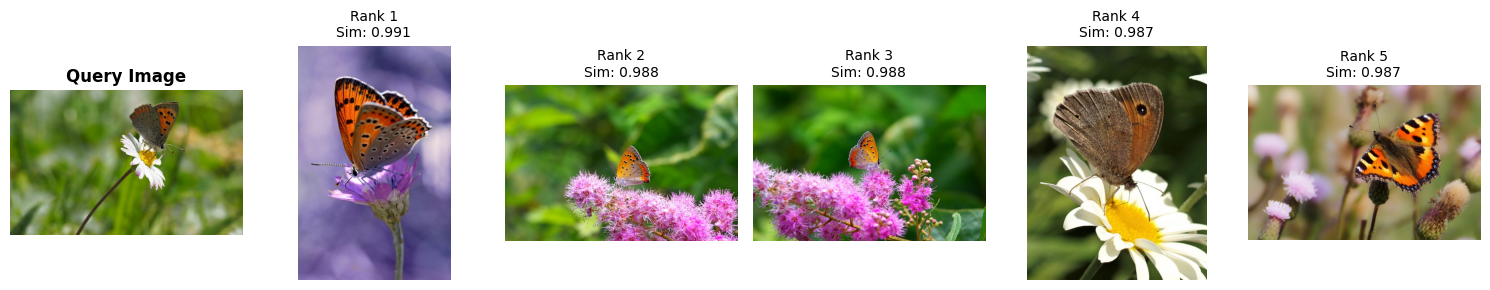

In [46]:
# Visualize the results
similar_paths = [r[0] for r in results[:5]]
similarities = [r[1] for r in results[:5]]

visualize_similar_images(query_image, similar_paths, similarities, max_display=5)


Query: e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg
Category: Unknown

Rank   Similarity   Category             Image
1      0.9906       butterfly            ea36b00d2bf6023ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
2      0.9906       butterfly            ea34b70720f7083ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
3      0.9902       butterfly            eb32b60c20f0093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
4      0.9891       butterfly            ea37b1082cf6063ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
5      0.9890       butterfly            ea37b10a21f5063ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
6      0.9887       butterfly            ea35b5092bf2033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
7      0.9883       butterfly            ea34b90b28fd093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
8      0.9877       butterfly            ed31b9072ae90021d8

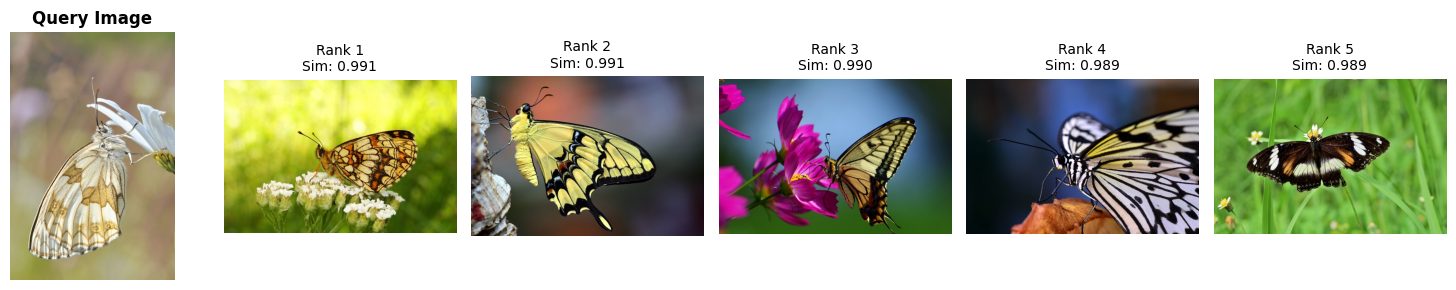

In [47]:
# Example 2: Query with a specific image (change the path)
specific_query = "../../datasets/animals/raw-img/butterfly/e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg"

if os.path.exists(specific_query):
    results = engine.find_similar_images(specific_query, top_k=10)
    print_results_table(specific_query, results)
    
    # Visualize
    similar_paths = [r[0] for r in results[:5]]
    similarities = [r[1] for r in results[:5]]
    visualize_similar_images(specific_query, similar_paths, similarities)
else:
    print(f"Image not found: {specific_query}")
    print("Update the path to a valid image in your dataset.")

In [48]:
# Example 3: Category-specific search
query_image = random.choice(engine.image_paths)
print(f"Query: {os.path.basename(query_image)}")

results_same_cat = engine.find_similar_images(query_image, top_k=10, same_category_only=True)
print("\nResults from SAME category only:")
print_results_table(query_image, results_same_cat)

Query: OIP-EQzBZOxAuGmaOBWq173PpgHaE7.jpeg

Results from SAME category only:

Query: OIP-EQzBZOxAuGmaOBWq173PpgHaE7.jpeg
Category: dog

Rank   Similarity   Category             Image
1      0.9953       dog                  OIP-Thiex1etn9dWM8u-zbU4ewHaFg.jpeg
2      0.9941       dog                  OIP-FjnHpsy-_xy2RgIzhNQLSQHaHI.jpeg
3      0.9940       dog                  OIP-qOp6HHdzcrGVbx-Hm5mnywHaNL.jpeg
4      0.9936       dog                  OIP-_BAWj2euFvq4uhzDOfSVEAHaE7.jpeg
5      0.9931       dog                  OIP-kH2EV7hkazCifeTdSexRMAHaE7.jpeg
6      0.9930       dog                  OIP-6do18OF3FYx4L_Vhqc4MYgHaGa.jpeg
7      0.9925       dog                  OIP-6F_n8kJDFBlVE0Qch5hfqwHaHL.jpeg
8      0.9921       dog                  OIP-MAlYwPFoSpoeS7pqYnT01AHaGL.jpeg
9      0.9920       dog                  OIP-pJ1VAsdJQC-hBThqb0VCvQHaFv.jpeg
10     0.9918       dog                  OIP-OVxXkoFSlMOq5u3iAxhIlwHaE7.jpeg


In [49]:
# Example 4: Diverse recommendations
query_image = random.choice(engine.image_paths)
print(f"Query: {os.path.basename(query_image)}")

# Standard search
results_standard = engine.find_similar_images(query_image, top_k=10)
print("\nStandard similarity search:")
print_results_table(query_image, results_standard, max_display=5)

# Diverse search
results_diverse = engine.get_recommendations(query_image, top_k=10, diversity_factor=0.5)
print("\nDiverse recommendations (diversity=0.5):")
print_results_table(query_image, results_diverse, max_display=5)

Query: OIP-uCWPd9Q7HcjW6B2nWkugewHaE7.jpeg

Standard similarity search:

Query: OIP-uCWPd9Q7HcjW6B2nWkugewHaE7.jpeg
Category: spider

Rank   Similarity   Category             Image
1      0.9982       spider               OIP-kC3eoTh6KFMpAu2Il2APhwHaLH.jpeg
2      0.9979       spider               OIP-9wxP7rdmJIeA8EBHKlcIKQHaE7.jpeg
3      0.9975       spider               OIP-KkOmJE7xBASALz_5PCaI5wHaE9.jpeg
4      0.9974       spider               OIP-pGihxbFt0b1bvbbgJYGLCAHaFj.jpeg
5      0.9971       spider               OIP-hzvbSH-TgK9ji2rll4e-fQHaE7.jpeg

Diverse recommendations (diversity=0.5):

Query: OIP-uCWPd9Q7HcjW6B2nWkugewHaE7.jpeg
Category: spider

Rank   Similarity   Category             Image
1      1.0000       spider               OIP-uCWPd9Q7HcjW6B2nWkugewHaE7.jpeg
2      0.9932       spider               OIP--1GKxNzkhVbR_eyVRCdp9QHaE6.jpeg
3      0.9876       spider               OIP--Bma656GiSO8H3qmvkDIzwHaE9.jpeg
4      0.9847       spider               OIP--Hu90LI

## 8. Comprehensive Demos

Try different categories!

In [50]:
# Demo 1: Cross-category similarities
print("Demo 1: Cross-Category Similarities")
print("="*80)

# Get one image from each category
from collections import defaultdict
category_samples = defaultdict(list)
for path in engine.image_paths:
    cat = engine.categories[path]
    category_samples[cat].append(path)

# Test a few
for category in list(category_samples.keys())[:3]:
    query = random.choice(category_samples[category])
    results = engine.find_similar_images(query, top_k=5)
    
    print(f"\nQuery: {category} - {os.path.basename(query)}")
    for i, (path, sim, cat) in enumerate(results, 1):
        marker = "✓" if cat == category else "✗"
        print(f"  {i}. [{marker}] {cat:15s} (sim: {sim:.4f})")

Demo 1: Cross-Category Similarities

Query: butterfly - OIP-owdI3zb2Mhzq5B2j0h6GsAHaEy.jpeg
  1. [✓] butterfly       (sim: 0.9853)
  2. [✓] butterfly       (sim: 0.9836)
  3. [✓] butterfly       (sim: 0.9831)
  4. [✓] butterfly       (sim: 0.9830)
  5. [✓] butterfly       (sim: 0.9830)

Query: cat - 258.jpeg
  1. [✓] cat             (sim: 0.9839)
  2. [✓] cat             (sim: 0.9803)
  3. [✓] cat             (sim: 0.9801)
  4. [✓] cat             (sim: 0.9801)
  5. [✓] cat             (sim: 0.9800)

Query: chicken - 21.jpeg
  1. [✓] chicken         (sim: 0.9996)
  2. [✓] chicken         (sim: 0.9930)
  3. [✓] chicken         (sim: 0.9930)
  4. [✓] chicken         (sim: 0.9930)
  5. [✓] chicken         (sim: 0.9923)


In [51]:
# Demo 2: Batch processing
print("Demo 2: Batch Processing")
print("="*80)

# Process multiple queries
test_queries = random.sample(engine.image_paths, 5)

for query in test_queries:
    results = engine.find_similar_images(query, top_k=3)
    query_cat = engine.categories[query]
    
    print(f"\nQuery: {query_cat} - {os.path.basename(query)}")
    print(f"  Top 3: ", end="")
    categories_found = [r[2] for r in results]
    print(" | ".join(categories_found))

Demo 2: Batch Processing

Query: dog - OIP-kjzhz566BXVXl6y7iAnqFgHaEp.jpeg
  Top 3: dog | dog | dog

Query: cat - 919.jpeg
  Top 3: cat | cat | cat

Query: chicken - OIP-dzvQ546uaCtGqy0eQOJ41gHaFj.jpeg
  Top 3: chicken | chicken | chicken

Query: cat - 1523.jpeg
  Top 3: cat | cat | cat

Query: chicken - OIP-kCpWuJvM2XBK1f93x4FOFwHaFj.jpeg
  Top 3: chicken | chicken | chicken


In [52]:
# Demo 3: Embedding analysis
print("Demo 3: Embedding Analysis")
print("="*80)

# Compute statistics
print(f"\nEmbedding Statistics:")
print(f"  Shape: {engine.embeddings.shape}")
print(f"  Mean norm: {np.linalg.norm(engine.embeddings, axis=1).mean():.4f}")
print(f"  Std norm: {np.linalg.norm(engine.embeddings, axis=1).std():.4f}")

# Check if normalized
norms = np.linalg.norm(engine.embeddings, axis=1)
is_normalized = np.allclose(norms, 1.0, atol=0.01)
print(f"  Normalized: {is_normalized}")

# Pairwise similarity distribution
sample_indices = random.sample(range(len(engine.embeddings)), min(100, len(engine.embeddings)))
sample_embeddings = engine.embeddings[sample_indices]
pairwise_sims = compute_cosine_similarity(sample_embeddings[0], sample_embeddings)

print(f"\nSample Pairwise Similarities:")
print(f"  Min: {pairwise_sims.min():.4f}")
print(f"  Max: {pairwise_sims.max():.4f}")
print(f"  Mean: {pairwise_sims.mean():.4f}")
print(f"  Std: {pairwise_sims.std():.4f}")

Demo 3: Embedding Analysis

Embedding Statistics:
  Shape: (52358, 128)
  Mean norm: 1.0000
  Std norm: 0.0000
  Normalized: True

Sample Pairwise Similarities:
  Min: -0.7047
  Max: 1.0000
  Mean: -0.1446
  Std: 0.4710


In [57]:
# Demo 4: Similarity distribution by category
print("Demo 4: Category Similarity Analysis")
print("="*80)

# For each category, compute average similarity to same vs different category
results_by_category = {}

for category in list(category_samples.keys())[:5]:
    query_paths = random.sample(category_samples[category], min(10, len(category_samples[category])))
    
    same_cat_sims = []
    diff_cat_sims = []
    
    for query_path in query_paths:
        results = engine.find_similar_images(query_path, top_k=20)
        
        for path, sim, cat in results:
            if cat == category:
                same_cat_sims.append(sim)
            else:
                diff_cat_sims.append(sim)
    
    if same_cat_sims and diff_cat_sims:
        results_by_category[category] = {
            'same': np.mean(same_cat_sims),
            'diff': np.mean(diff_cat_sims)
        }

print(f"\n{'Category':<15} {'Same Category':<12} {'Diff Category':<12} {'Margin'}")
print("-" * 55)
for cat, sims in results_by_category.items():
    margin = sims['same'] - sims['diff']
    print(f"{cat:<15} {sims['same']:<12.4f} {sims['diff']:<12.4f} {margin:>+.4f}")

Demo 4: Category Similarity Analysis

Category        Same Category Diff Category Margin
-------------------------------------------------------


Demo 5: Visualization Grid


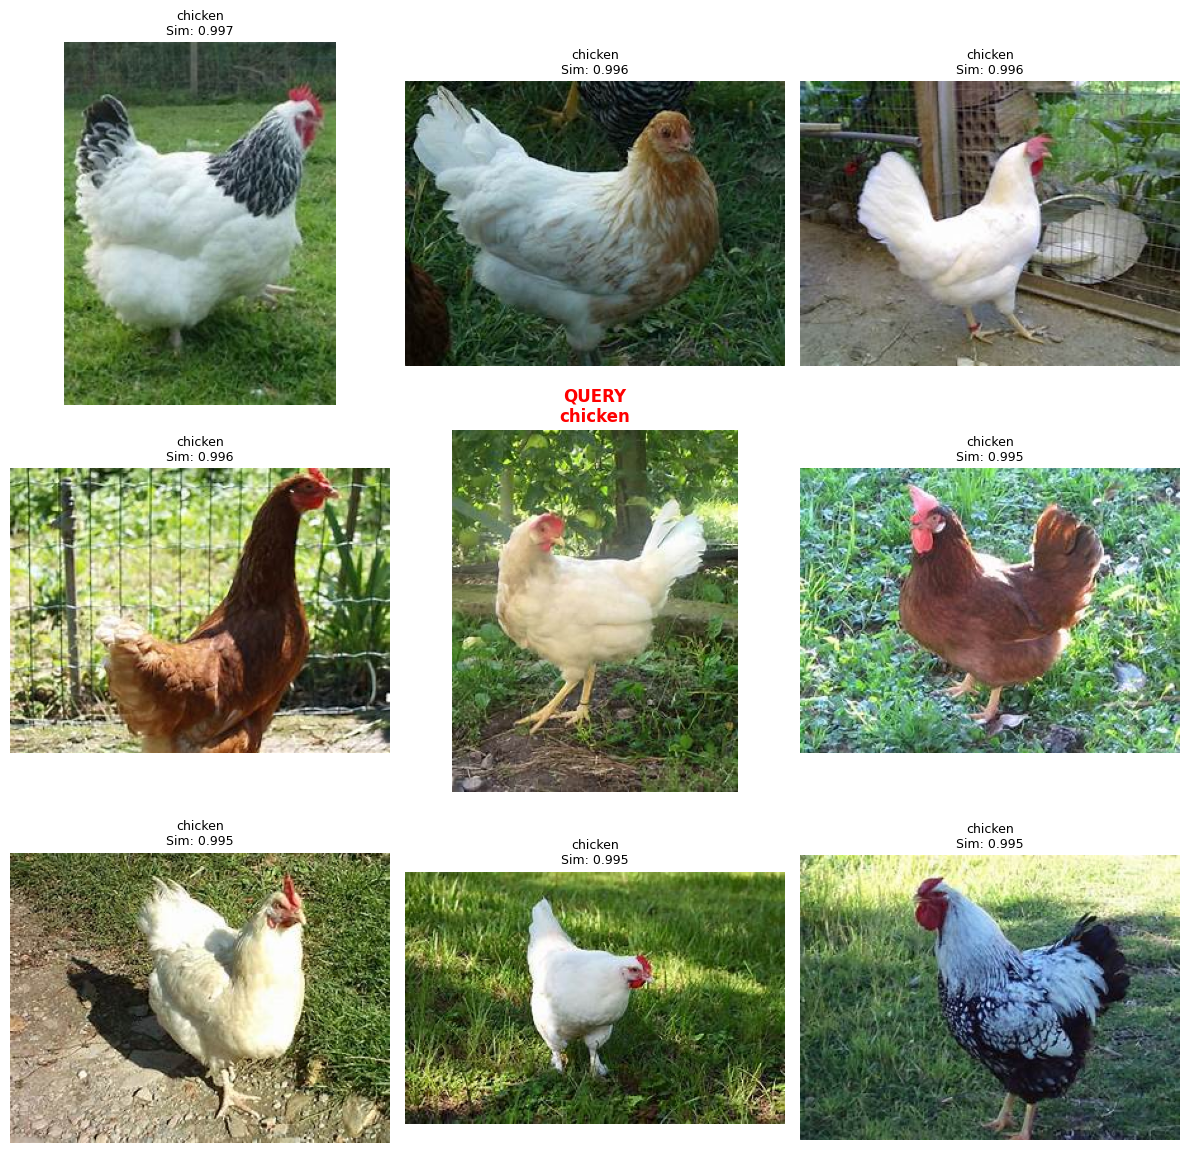

In [58]:
# Demo 5: Visualization grid
print("Demo 5: Visualization Grid")
print("="*80)

# Create a grid of query and results
query_image = random.choice(engine.image_paths)
results = engine.find_similar_images(query_image, top_k=9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Query in center
query_img = Image.open(query_image)
axes[4].imshow(query_img)
axes[4].set_title('QUERY\n' + engine.categories[query_image], fontsize=12, fontweight='bold', color='red')
axes[4].axis('off')
axes[4].spines['top'].set_color('red')
axes[4].spines['bottom'].set_color('red')
axes[4].spines['left'].set_color('red')
axes[4].spines['right'].set_color('red')
axes[4].spines['top'].set_linewidth(3)
axes[4].spines['bottom'].set_linewidth(3)
axes[4].spines['left'].set_linewidth(3)
axes[4].spines['right'].set_linewidth(3)

# Results around it
positions = [0, 1, 2, 3, 5, 6, 7, 8]
for pos, (path, sim, cat) in zip(positions, results[:8]):
    img = Image.open(path)
    axes[pos].imshow(img)
    axes[pos].set_title(f'{cat}\nSim: {sim:.3f}', fontsize=9)
    axes[pos].axis('off')

plt.tight_layout()
plt.show()